# **Codig Dojo**: Proyecto 2, predicción de probabilidad de matriculación.
## Creado por: Alejandro Acosta

- Fecha de creación: 2022-02-22
- Fecha de modificación: 2022-03-02
- Descripción: En base a ciertas características de postulantes a una universidad privada de Ecuador, se estima la probabilidad de matriculación de un estudiante universitario de pregrado y cuáles son los factores más importantes que influyen en dicha matriculación.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels import OLS

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

sns.set()
plt.rcParams['figure.dpi'] = 100

## Importación y limpieza de datos

In [2]:
df = pd.read_csv('alumnos.csv')
df.head()

,id_oportunidad,id_estudiante,programa,etapa,fecha_afluencia,fecha_ganado,fecha_perdido,consultor,edad,estado_civil,ciudad,provincia,trabaja,colegio,tipo_admision,origen,enteraste
0,0068W00000RtT5E,-7959495189833833808,1P714,Cerrada Perdida,2022-01-20 00:00:00,NaN,2022-02-11 00:00:00,36,25.0,Casado/a,QUITO,PICHINCHA,Si,1978,Normal,Whatsapp,Recomendado
1,0068W00000RulbV,8433271449132097132,1P734,Cerrada Perdida,2022-02-02 00:00:00,NaN,2022-02-02 00:00:00,8,21.0,NaN,QUITO,PICHINCHA,NaN,1002,Normal,Simulador Homologación,NaN
2,0061U00000NB058,681923597971309571,1P614,Cerrada Perdida,2021-07-22 00:00:00,NaN,2021-07-28 00:00:00,15,19.0,NaN,QUITO,PICHINCHA,No,18,Normal,Colegios,Mi colegio
3,0061U00000NjOPF,-1854769890286518797,1H003,Cerrada Perdida,2021-09-03 00:00:00,NaN,2021-10-06 00:00:00,15,36.0,Casado/a,CHONE,MANABI,Si,1905,Convalidado,Llamada,Redes sociales
4,0061U00000Mm1LY,5707294226770007228,1P244,Cerrada Perdida,2021-06-10 00:00:00,NaN,2021-07-29 00:00:00,16,25.0,Soltero/a,QUITO,PICHINCHA,No,94,Convalidado,Simulador Homologación,Aplicaciones


In [14]:
df = pd.read_csv('alumnos.csv')

# me enfocaré en la cartera cerrada:
df = df[df.etapa.str.startswith('Cerrada')]

# limpieza de variables
df['etapa'] = df.etapa.map({'Cerrada Perdida':'perdida', 'Cerrada Ganada':'ganada'})
df['fecha_afluencia'] = df['fecha_afluencia'].astype('datetime64')
df['fecha_ganado'] = np.where(df.etapa=='ganada', df.fecha_ganado, df.fecha_perdido).astype('datetime64')
df['fecha_perdido'] = (df.fecha_ganado - df.fecha_afluencia).dt.days
df.rename(columns={'fecha_ganado':'fecha_cierre','fecha_perdido':'ciclo'} , inplace=True)
df['afl'] = 1
df['doc'] = np.where(df.etapa=='ganada',1,0)

df.head()

,id_oportunidad,id_estudiante,programa,etapa,fecha_afluencia,fecha_cierre,ciclo,consultor,edad,estado_civil,ciudad,provincia,trabaja,colegio,tipo_admision,origen,enteraste,afl,doc
0,0068W00000RtT5E,-7959495189833833808,1P714,perdida,2022-01-20,2022-02-11,22,36,25.0,Casado/a,QUITO,PICHINCHA,Si,1978,Normal,Whatsapp,Recomendado,1,0
1,0068W00000RulbV,8433271449132097132,1P734,perdida,2022-02-02,2022-02-02,0,8,21.0,NaN,QUITO,PICHINCHA,NaN,1002,Normal,Simulador Homologación,NaN,1,0
2,0061U00000NB058,681923597971309571,1P614,perdida,2021-07-22,2021-07-28,6,15,19.0,NaN,QUITO,PICHINCHA,No,18,Normal,Colegios,Mi colegio,1,0
3,0061U00000NjOPF,-1854769890286518797,1H003,perdida,2021-09-03,2021-10-06,33,15,36.0,Casado/a,CHONE,MANABI,Si,1905,Convalidado,Llamada,Redes sociales,1,0
4,0061U00000Mm1LY,5707294226770007228,1P244,perdida,2021-06-10,2021-07-29,49,16,25.0,Soltero/a,QUITO,PICHINCHA,No,94,Convalidado,Simulador Homologación,Aplicaciones,1,0


### Valores perdidos

In [4]:
df.isna().sum()/df.shape[0]

id_oportunidad     0.000000
id_estudiante      0.000000
programa           0.000000
etapa              0.000000
fecha_afluencia    0.000000
fecha_cierre       0.000000
ciclo              0.000000
consultor          0.000000
edad               0.032853
estado_civil       0.117170
ciudad             0.038597
provincia          0.030862
trabaja            0.079568
colegio            0.000000
tipo_admision      0.000000
origen             0.252642
enteraste          0.086690
doc                0.000000
dtype: float64

<AxesSubplot:>

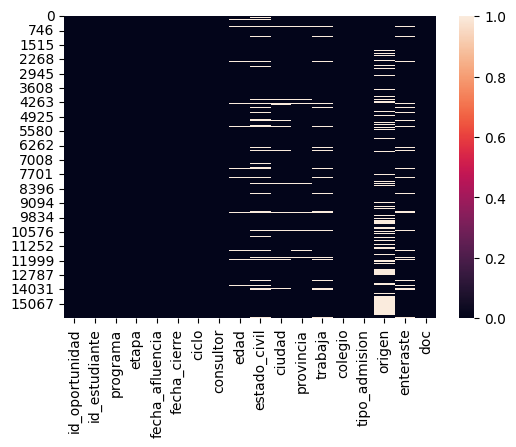

In [5]:
sns.heatmap(df.isna())

- Los valores perdidos en el origen del candidato son imposibles de imputar y su ausencia de valor no representa nada. Este campo se llena automáticamente mediante una interfáz del CRM. Se eliminará esta variable.
- Por otro lado, los valores perdidos de variables que se preguntan al candidato como: su estado civil, edad, ciudad de residencia, estatus labora y ¿cómo te enteraste de la universidad?. Nos pueden dar información acerca del interés del candidato en la oferta académica; un postulante con poco interés puede o no dar 

## Estadística descriptiva

<AxesSubplot:xlabel='etapa', ylabel='Count'>

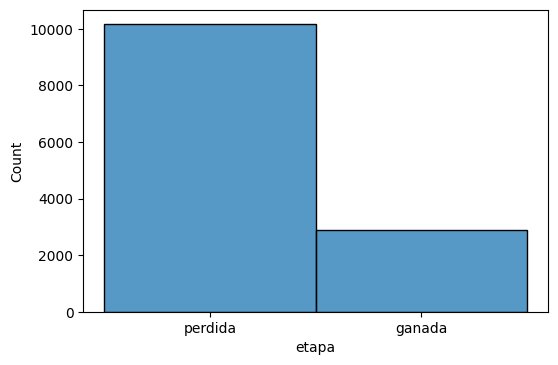

In [6]:
sns.histplot(data=df, x='etapa')


In [9]:
# conversión
df.doc.mean()

0.22124368203400213

<AxesSubplot:xlabel='ciclo', ylabel='Count'>

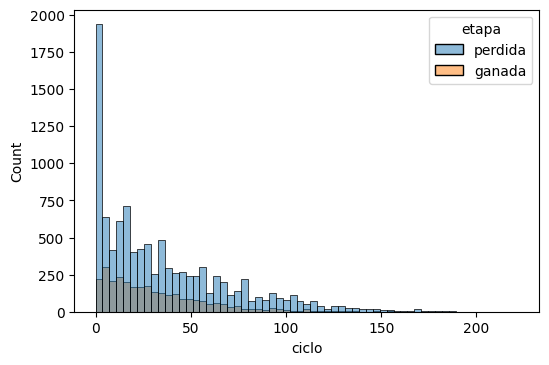

In [10]:
sns.histplot(data=df, x='ciclo', hue='etapa')

un ciclo muy corto sugiere una baja probabilidad de matricularse

<AxesSubplot:>

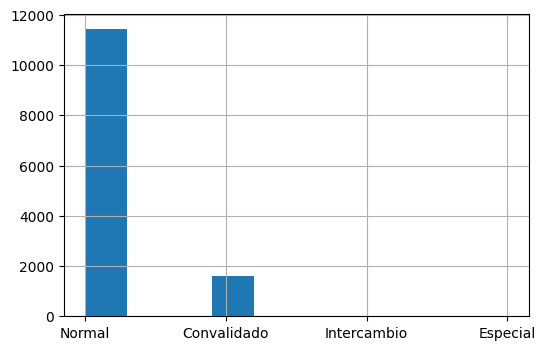

In [11]:
df.tipo_admision.hist()

muy pocas observaciones de intercambio y especial, se eliminan las variables

In [12]:
df = df[~df.tipo_admision.isin(['Intercambio','Especial'])]

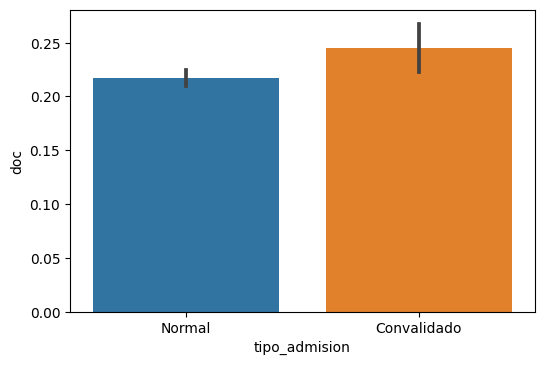

In [13]:
sns.barplot(data=df, x='tipo_admision', y='doc')
plt.show()

<AxesSubplot:xlabel='afl', ylabel='doc'>

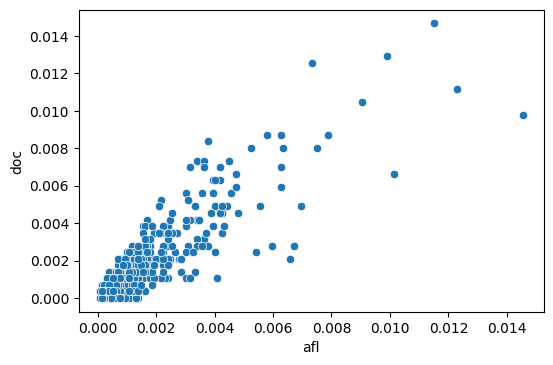

In [28]:
dft = df.pivot_table(index='colegio', values=['afl','doc'], aggfunc=np.sum).drop(-1)

dft['afl'] = dft['afl']/dft['afl'].sum()
dft['doc'] = dft['doc']/dft['doc'].sum()

sns.scatterplot(x=dft.afl, y=dft.doc)


Se observa una fuerte correlación entre la cantidad de afluencias y matriculados en los colegios.